* To investigate the forcings on stratification and total currents. 

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz 
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'j' : 46,
        'i' : 53   
    },
    'VENUS East':{
        'lat': 49.0419,
        'lon': -123.3176,
        'depth': 170, 
        'j': 36,##should be 416,
        'i': 43,##should be 283
    },    
    'VENUS Central':{
        'lat': 49.0401,
        'lon': -123.4261,
        'depth': 300,
        'j': 44,##should be 424,
        'i': 26,##should be 266
    },
    }

* Load model result
* Only river

In [3]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No tides

In [4]:
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No winds

In [5]:
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')

* No f

In [6]:
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')

* Combine all forcings

In [7]:
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [8]:
def plot_stratification_current(stn, dep_ind,ty,grid_T,grid_U,grid_V,cmin = 0,cmax = 36,vmin = -0.3,vmax = 0.3):
    """This function is made to plot the 
    stratification and horizontal current of a specific station """
    S = grid_T.variables['vosaline']
    t = grid_T.variables['time_counter']
    dep = grid_T.variables['deptht']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    S_stn = S[:,:,sites[stn]['j'],sites[stn]['i']]
    fig, axs = plt.subplots(1,3,figsize = (22,4))
    ## stratification
    ax = axs[0]
    mesh = ax.contourf(np.transpose(S_stn[:]),np.arange(cmin, cmax, 3),cmap = 'jet')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('Practical Salinity')
    ax.set_title(ty+' stratification of '+stn)
    ## U current
    ax = axs[1]
    mesh = ax.contourf(np.transpose(U[:,:,sites[stn]['j'],sites[stn]['i']]),\
                                    np.arange(vmin, vmax, 0.03),cmap = 'cool')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('U Velocity [m/s]')
    ax.set_title(ty+' U velocity of '+stn)
    ## V current
    ax = axs[2]
    mesh = ax.contourf(np.transpose(V[:,:,sites[stn]['j'],sites[stn]['i']]),\
                       np.arange(vmin, vmax, 0.03),cmap = 'cool')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('V Velocity [m/s]')
    ax.set_title(ty+' V velocity of '+stn)
    for ax in axs:
        ax.set_ylim([dep[dep_ind], dep[0]])
        ax.set_xlim(0,744)
        ax.set_xlabel('Time [hr]')
        ax.set_ylabel('Depth_index ')
    return fig

# stratification and horizontal currents

* Sandheads

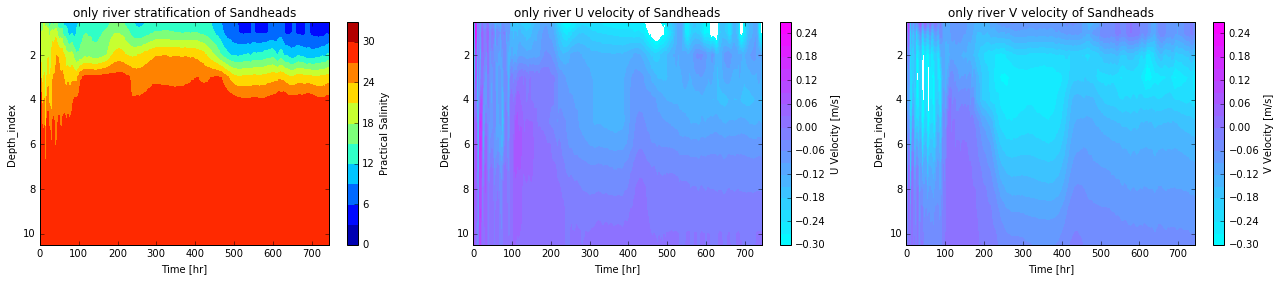

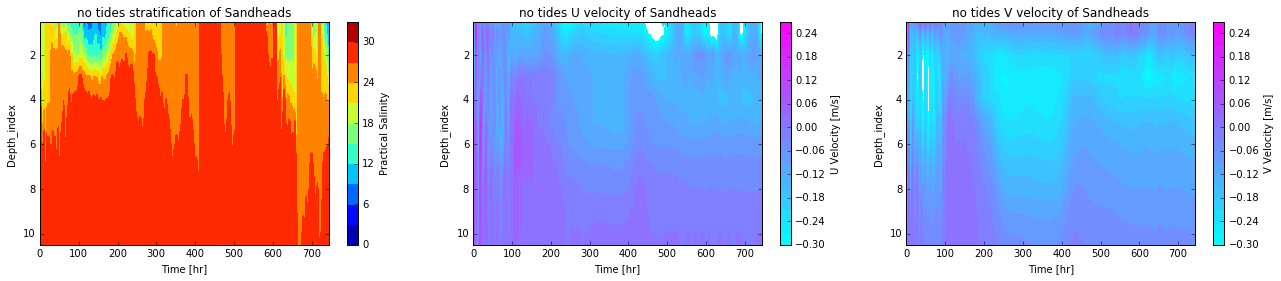

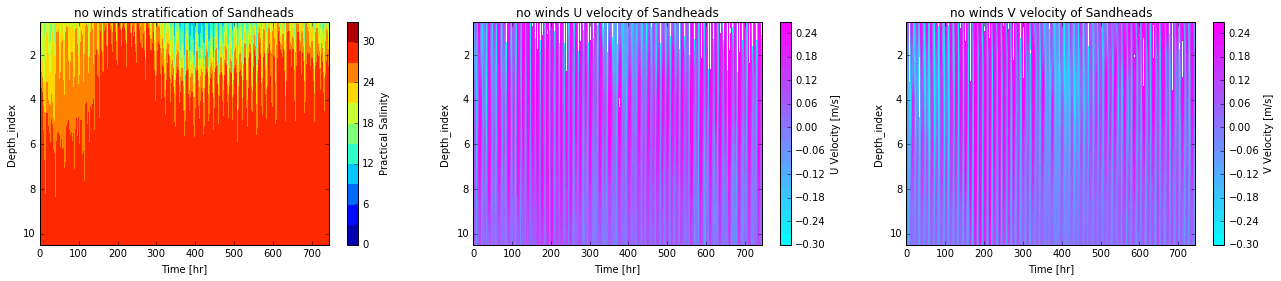

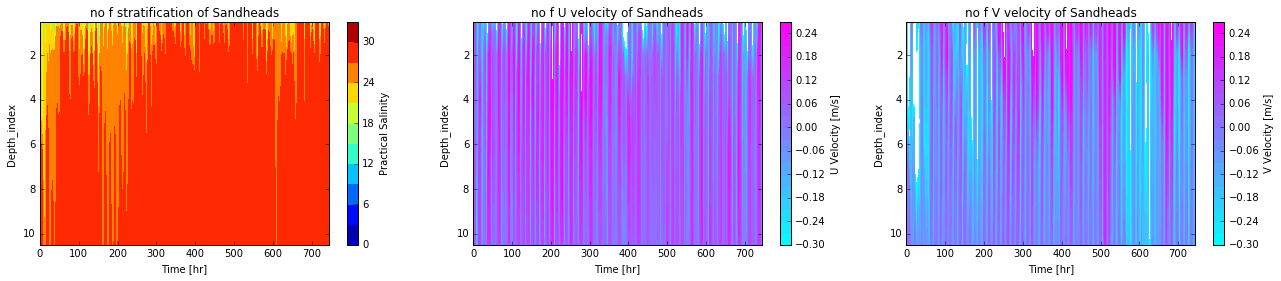

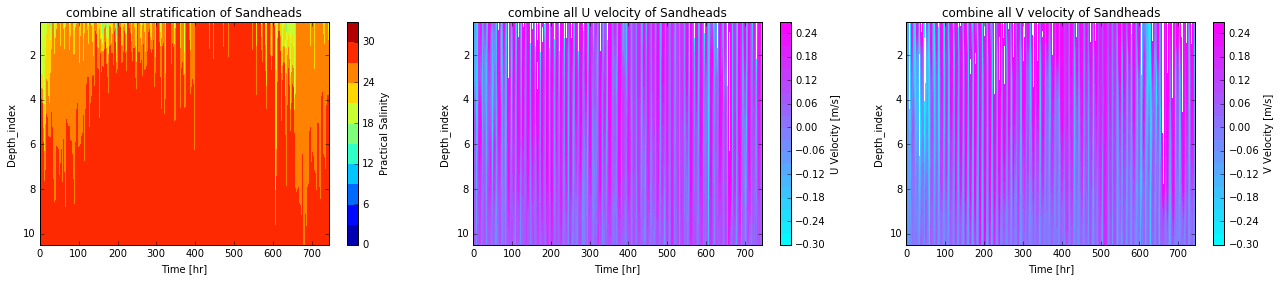

In [9]:
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V)

* VENUS Central

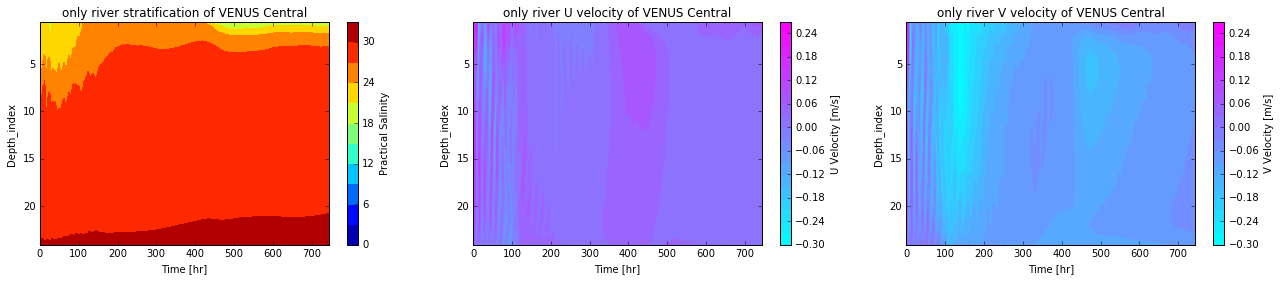

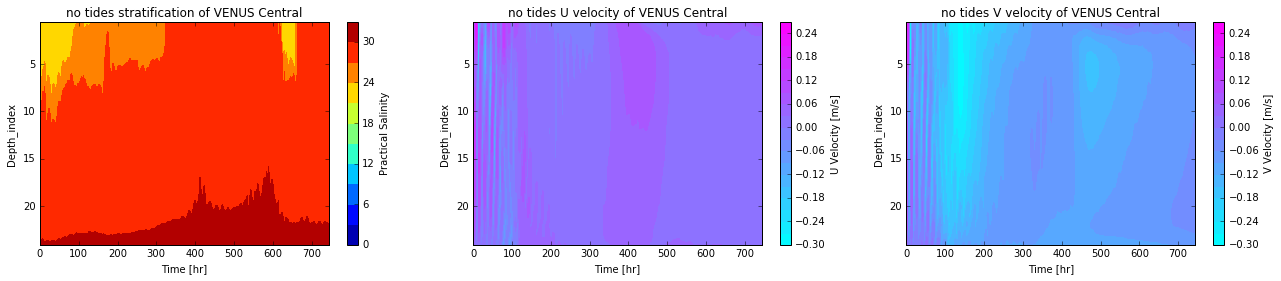

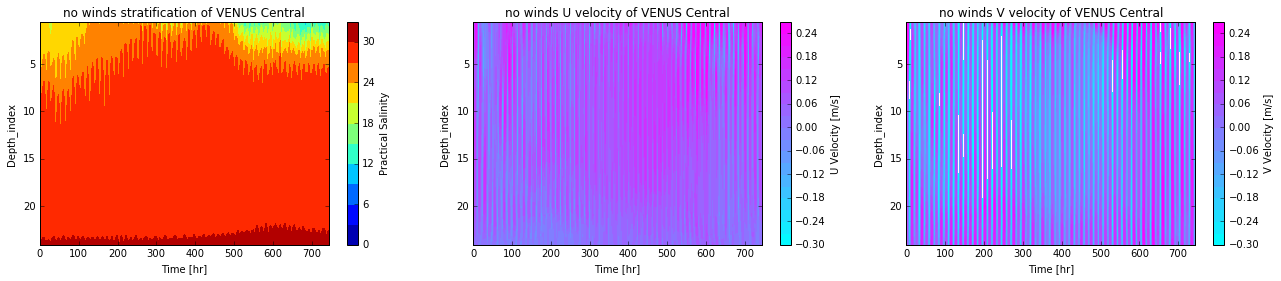

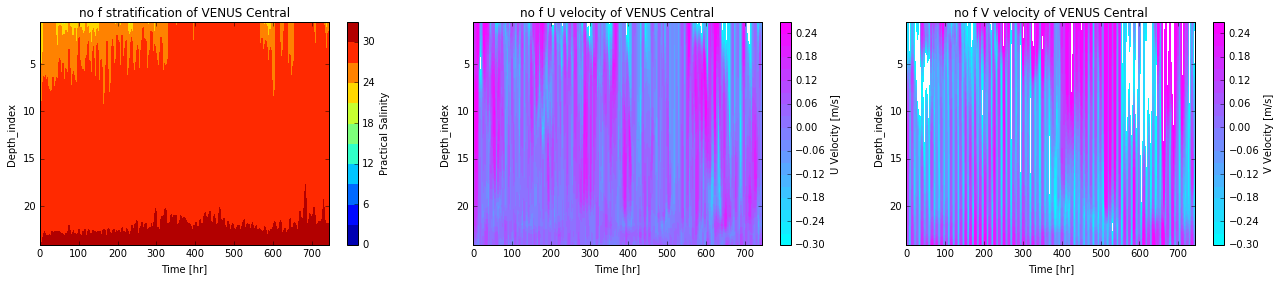

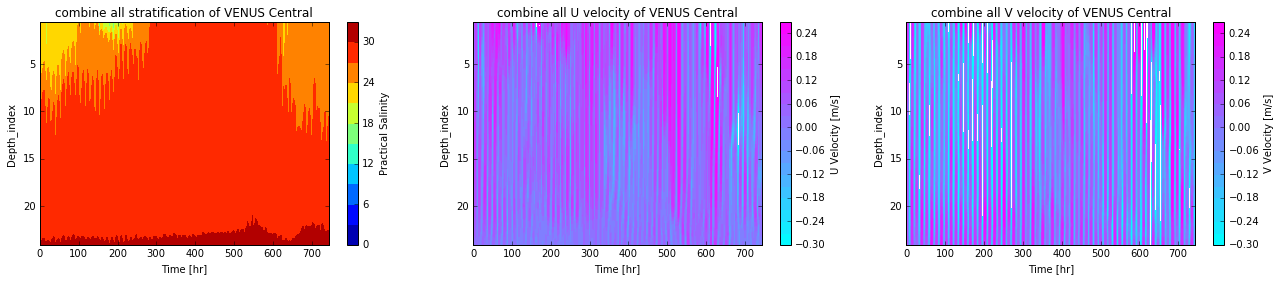

In [10]:
fig = plot_stratification_current('VENUS Central',20,'only river',river_T,river_U,river_V)
fig = plot_stratification_current('VENUS Central',20,'no tides',notide_T,notide_U,notide_V)
fig = plot_stratification_current('VENUS Central',20,'no winds',nowind_T,nowind_U,nowind_V)
fig = plot_stratification_current('VENUS Central',20,'no f',nof_T,nof_U,nof_V)
fig = plot_stratification_current('VENUS Central',20,'combine all',all_T,all_U,all_V)

* VENUS East

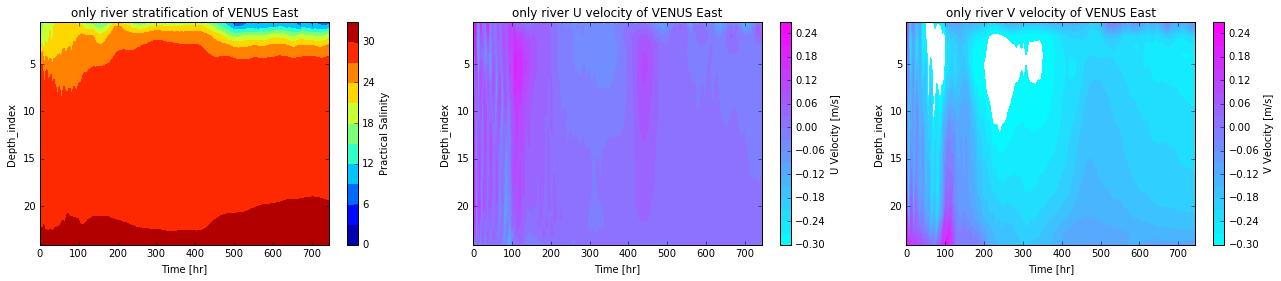

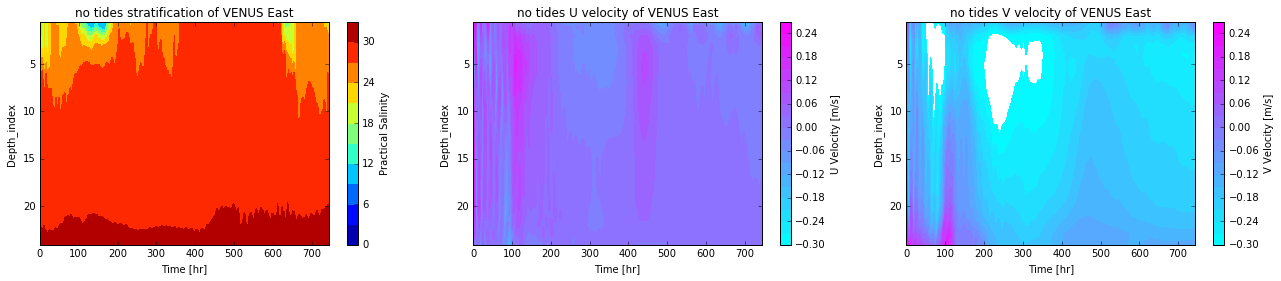

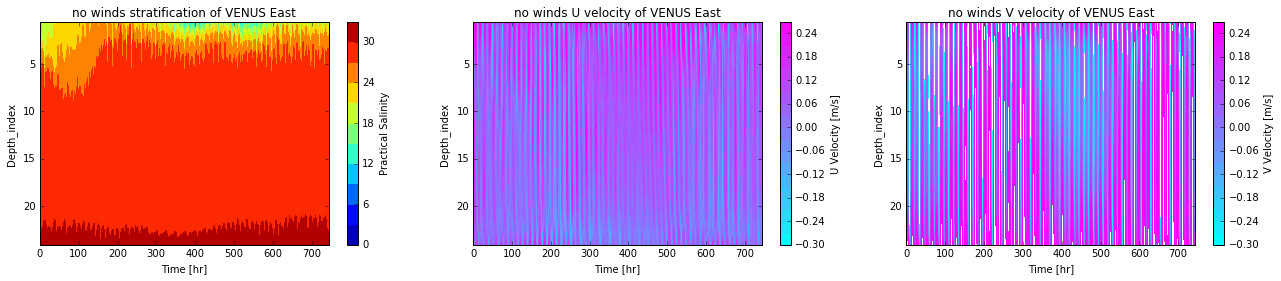

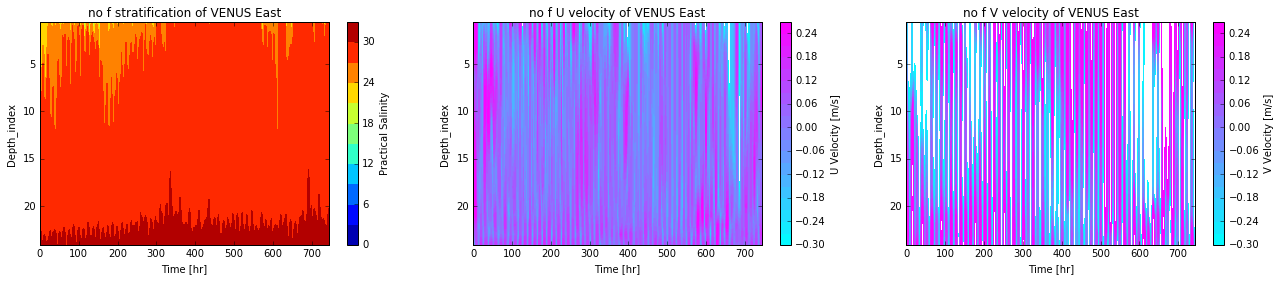

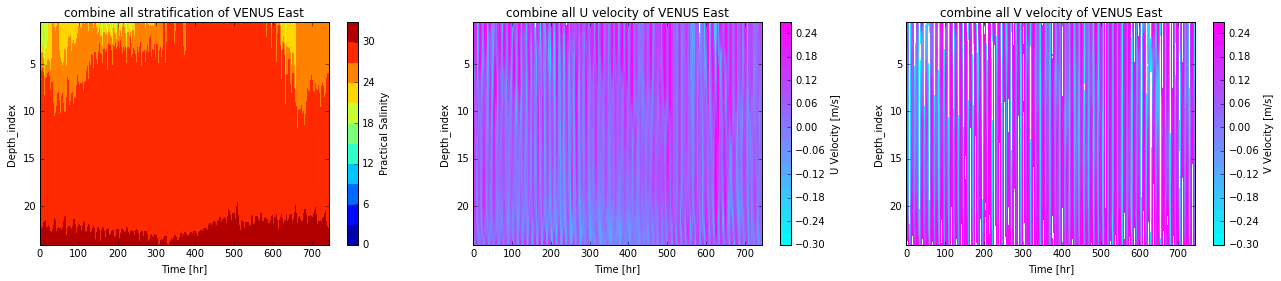

In [11]:
fig = plot_stratification_current('VENUS East',20,'only river',river_T,river_U,river_V)
fig = plot_stratification_current('VENUS East',20,'no tides',notide_T,notide_U,notide_V)
fig = plot_stratification_current('VENUS East',20,'no winds',nowind_T,nowind_U,nowind_V)
fig = plot_stratification_current('VENUS East',20,'no f',nof_T,nof_U,nof_V)
fig = plot_stratification_current('VENUS East',20,'combine all',all_T,all_U,all_V)